In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

rng = np.random.RandomState(0)

df_train = pd.read_csv('../src/t_train.csv', 
                       encoding='utf-8')
df_test  = pd.read_csv('../src/t_test.csv' , 
                       encoding='utf-8')
df_test.head()

numerical = ['Age', 'SibSp', 'Parch', 'Fare', 'isMr', 'isMrs', 'isMiss']
categorical = ['Pclass', 'Sex', 'Embarked', 'cabin_encoding']
target = ['Survived']

x, y = df_train[numerical+categorical], df_train[target]

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

x = pd.get_dummies(x, columns=categorical, drop_first=True)
colunas = x.columns

imr = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imr = imr.fit(x)
x = imr.transform(x)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=rng, stratify=y)

In [156]:

from sklearn.model_selection import learning_curve



def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    return plt


In [162]:
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import os

def learning_curves(x, y, ylim=None, random_state=None, savefig=False, pic_name='default'):

    fig, axes = plt.subplots(2, 6, figsize=(25, 10))

    title = "Naive Bayes"
    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=random_state)

    estimator = GaussianNB()
    plot_learning_curve(estimator, title, x, y, axes=axes[:, 0],  ylim=ylim,
                        cv=cv, n_jobs=4)

    title = r"SVM, RBF kernel, $\gamma=0.001$"
    # SVC is more expensive so we do a lower number of CV iterations:
    estimator = SVC(gamma=0.001)
    plot_learning_curve(estimator, title, x, y, axes=axes[:, 1], ylim=ylim,
                        cv=cv, n_jobs=4)

    title = r"Random Forest, Default"
    estimator = RandomForestClassifier()
    plot_learning_curve(estimator, title, x, y, axes=axes[:, 2],  ylim=ylim,
                        cv=cv, n_jobs=4)

    title = r"Light GBM, Default"
    estimator = LGBMClassifier()
    plot_learning_curve(estimator, title, x, y, axes=axes[:, 3],  ylim=ylim,
                        cv=cv, n_jobs=4)

    title = r"Random Forest, depth=5, predictors=50"
    estimator = RandomForestClassifier(n_estimators=50, max_depth=5)
    plot_learning_curve(estimator, title, x, y, axes=axes[:, 4],  ylim=ylim,
                        cv=cv, n_jobs=4)

    title = r"Logistic, Default (Not Scaled)"
    estimator = LogisticRegression(max_iter=1000)
    plot_learning_curve(estimator, title, x, y, axes=axes[:, 5],  ylim=ylim,
                        cv=cv, n_jobs=4)

    plt.tight_layout()
    
    if savefig:
        if not os.path.exists('../figures'):
            os.makedirs('../figures')
            
        file = os.path.join('../figures', pic_name + '_lc_.jpg')
        plt.savefig(file, dpi=150)
    
    plt.show()

In [152]:
learning_curves(x_train, y_train.values.ravel(), random_state=rng, savefig=True, ylim=(0.6, 1.01), 'jabuti')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

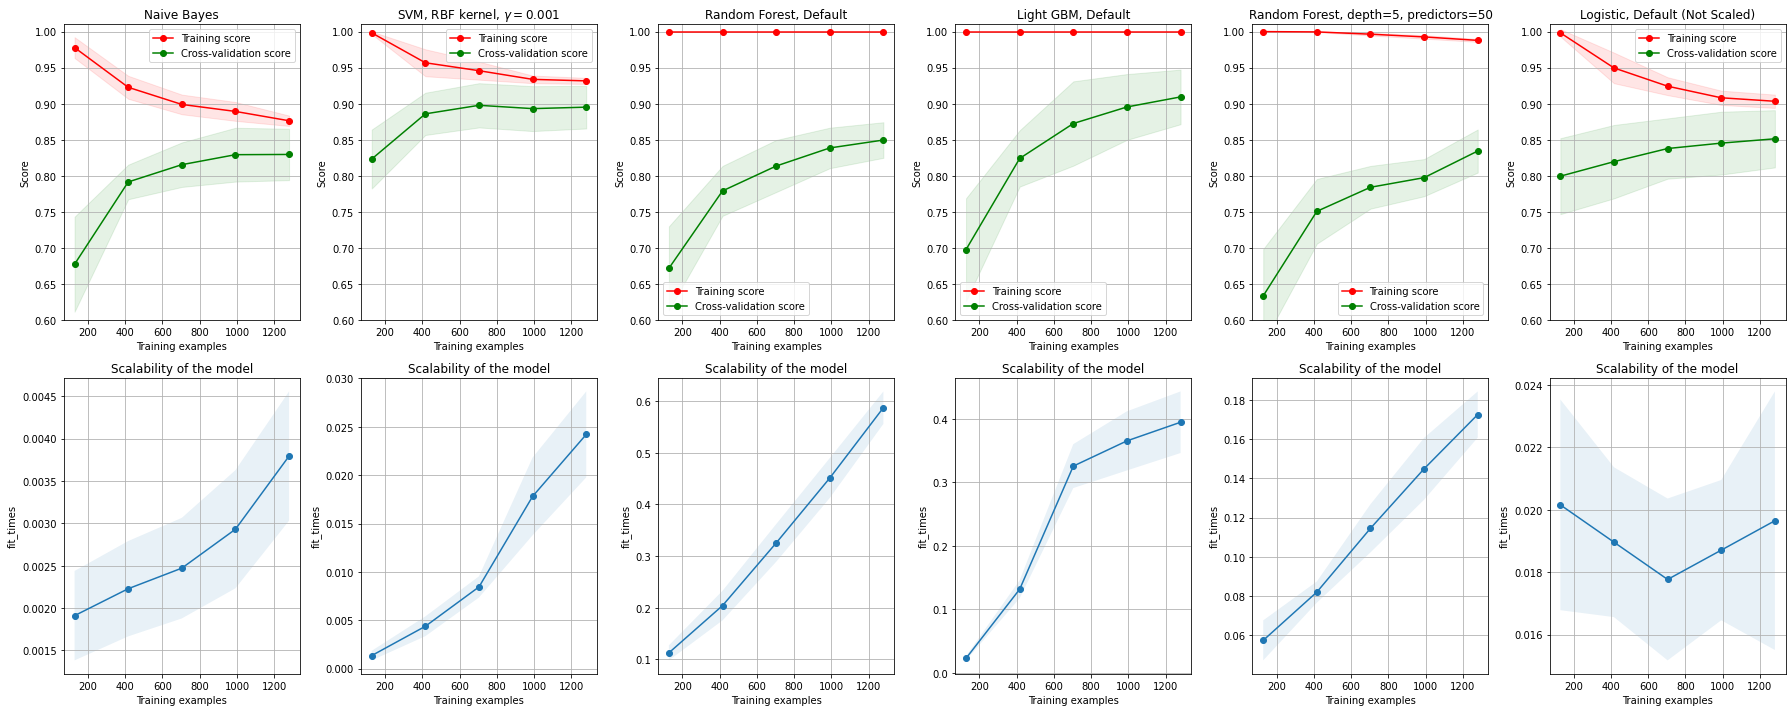

/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 334, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  

/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 362, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/h

In [166]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=2000, n_features=50, n_informative=15, n_redundant=5,
    n_repeated=2, n_classes=2, random_state=rng, shuffle=False, weights=[0.90])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=rng, test_size=0.20)


learning_curves(X_train, y_train, random_state=rng, savefig=True, ylim=(0.6, 1.01), pic_name='synthetic')

Best Parameters
	 {'skb__k': 8, 'clf__penalty': 'l1', 'clf__C': 8.0}


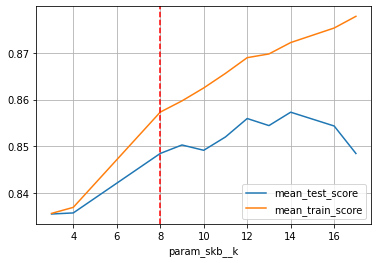

Melhor modelo simples
{'skb__k': 8, 'clf__penalty': 'l1', 'clf__C': 8.0}
['Fare', 'isMr', 'isMrs', 'isMiss', 'Pclass_3', 'Sex_male', 'cabin_encoding_B', 'cabin_encoding_M']
TEST  82.98
TRAIN 85.78


In [82]:
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Select K Best
params = {'skb__k': range(2, x.shape[1] + 1), 
          'clf__C': [x for x in np.linspace(1, 100, 100)],
          'clf__penalty': ['l1', 'l2']}
    

classifier_1 = Pipeline([('skb', SelectKBest(chi2)),
                         ('scaler', StandardScaler()),
                         ('clf', LogisticRegression(max_iter=2000, solver='liblinear'))])

grid = RandomizedSearchCV(classifier_1, 
                    params, 
                    scoring='roc_auc',
                    n_iter=1000,
                    n_jobs=5,
                    cv=5,
                    verbose=-1,
                    return_train_score=True)

grid.fit(x_train, y_train.values.ravel())

# cuttoff
results = pd.DataFrame(grid.cv_results_)
conditions = results['std_test_score'] <= results['std_test_score'].describe()['50%']
conditions = np.logical_and(conditions, \
                           (results['mean_train_score'] - results['mean_test_score']) < 0.03)
results = results[conditions]

results.sort_values(by=['param_skb__k', 'rank_test_score'], ascending=True, inplace=True)
results.drop_duplicates(subset=['param_skb__k'], keep='first', inplace=True)

results_plot = results.loc[:, ['param_skb__k', 'mean_test_score', 'mean_train_score']]
results_plot.set_index('param_skb__k', inplace=True)
# Select best within margin
threshold = results_plot.mean_test_score.max() - 0.01
best_est = results_plot.loc[results_plot.mean_test_score >= threshold, :].index.min()

print("Best Parameters")
print("\t", results.loc[results.param_skb__k == best_est].params.values[0])


results_plot.plot()
plt.grid()
plt.axvline(best_est, color='red', ls='--')
plt.show()

# -------------------

simple_params = results.loc[results.param_skb__k == best_est].params.values[0]

classifier_1.set_params(**simple_params)
classifier_1.fit(x_train, y_train.values.ravel())
features = colunas[classifier_1.named_steps['skb'].get_support()]

# Refazendo as features
x_train_refactored =  x_train[:, classifier_1.named_steps['skb'].get_support()]
x_test_refactored  =  x_test[:, classifier_1.named_steps['skb'].get_support()]

model = LogisticRegression(**classifier_1.named_steps['clf'].get_params())
model.fit(x_train_refactored, y_train.values.ravel())

print("Melhor modelo simples\n%s\n%s" % (simple_params, features.tolist()))
prob = model.predict_proba(x_test_refactored)[:, 1]
print("TEST  %4.2f" % (roc_auc_score(y_test, prob) * 100))
prob = model.predict_proba(x_train_refactored)[:, 1]
print("TRAIN %4.2f" % (roc_auc_score(y_train, prob) * 100))

In [91]:
classifier_1.named_steps['clf'].coef_a

array([[ 0.14516804, -0.64788003,  0.01665409, -0.63336382, -0.51875005,
        -1.40685068, -0.03305547, -0.42876251]])

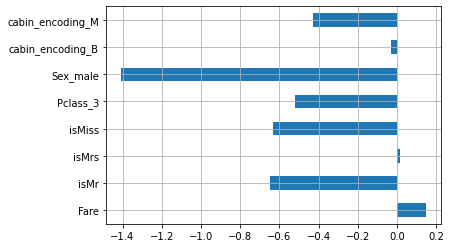

[CV] END clf__learning_rate=0.01, clf__num_leaves=72, sfm__max_features=16; total time=   0.3s
[CV] END clf__learning_rate=0.001, clf__num_leaves=26, sfm__max_features=8; total time=   0.3s
[CV] END clf__learning_rate=0.1, clf__num_leaves=36, sfm__max_features=4; total time=   0.3s
[CV] END clf__learning_rate=0.3, clf__num_leaves=47, sfm__max_features=5; total time=   0.3s
[CV] END clf__learning_rate=0.001, clf__num_leaves=11, sfm__max_features=10; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=81, sfm__max_features=19; total time=   0.3s
[CV] END clf__learning_rate=0.001, clf__num_leaves=60, sfm__max_features=11; total time=   0.3s
[CV] END clf__learning_rate=0.05, clf__num_leaves=11, sfm__max_features=4; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=92, sfm__max_features=19; total time=   0.3s
[CV] END clf__learning_rate=0.3, clf__num_leaves=79, sfm__max_features=12; total time=   0.3s
[CV] END clf__learning_rate=0.3, clf__num_leaves=93, sfm

[CV] END clf__learning_rate=0.5, clf__num_leaves=35, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=11, sfm__max_features=20; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=48, sfm__max_features=12; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=53, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=36, sfm__max_features=9; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=3, sfm__max_features=6; total time=   0.3s
[CV] END clf__learning_rate=0.5, clf__num_leaves=60, sfm__max_features=15; total time=   0.3s
[CV] END clf__learning_rate=0.01, clf__num_leaves=99, sfm__max_features=7; total time=   0.3s
[CV] END clf__learning_rate=0.5, clf__num_leaves=35, sfm__max_features=11; total time=   0.3s
[CV] END clf__learning_rate=0.001, clf__num_leaves=67, sfm__max_features=8; total time=   0.3s
[CV] END clf__learning_rate=0.1, clf__num_leaves=20, sfm__

In [97]:
importances = pd.Series(classifier_1.named_steps['clf'].coef_[0])
importances.index = ['Fare', 'isMr', 'isMrs', 'isMiss', 'Pclass_3', 'Sex_male', 'cabin_encoding_B', 'cabin_encoding_M']
importances.plot.barh()
plt.grid()
plt.show()

/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-pack

Best Parameters
	 {'sfm__max_features': 12, 'clf__min_samples_leaf': 16, 'clf__max_depth': 8}


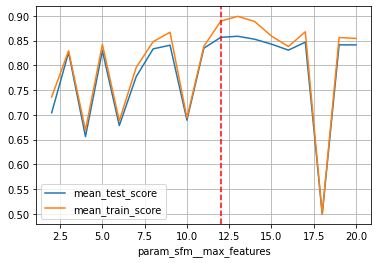

Melhor modelo simples
{'sfm__max_features': 12, 'clf__min_samples_leaf': 16, 'clf__max_depth': 8}
['Age', 'SibSp', 'Fare', 'Pclass_3', 'Sex_male']
TEST  82.72
TRAIN 90.06


In [125]:
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Select K Best
params = {'sfm__max_features': range(2, x.shape[1] + 1), 
          'clf__max_depth': range(1, 10),
          'clf__min_samples_leaf': range(1, 500)}
    
classifier_1 = Pipeline([('sfm', SelectFromModel(RandomForestClassifier(n_estimators=30))),
                         ('clf', RandomForestClassifier(n_estimators=30))])

grid = RandomizedSearchCV(classifier_1, 
                    params, 
                    scoring='roc_auc',
                    n_iter=500,
                    n_jobs=5,
                    cv=5,
                    verbose=-1,
                    return_train_score=True)

grid.fit(x_train, y_train.values.ravel())

results = pd.DataFrame(grid.cv_results_)
conditions = results['std_test_score'] <= results['std_test_score'].describe()['75%']
conditions = np.logical_and(conditions, \
                           (results['mean_train_score'] - results['mean_test_score']) < 0.05)
results = results[conditions]

results.sort_values(by=['param_sfm__max_features', 'rank_test_score'], ascending=True, inplace=True)
results.drop_duplicates(subset=['param_sfm__max_features'], keep='first', inplace=True)

results_plot = results.loc[:, ['param_sfm__max_features', 'mean_test_score', 'mean_train_score']]
results_plot.set_index('param_sfm__max_features', inplace=True)
# Select best within margin
threshold = results_plot.mean_test_score.max() - 0.01
best_est = results_plot.loc[results_plot.mean_test_score >= threshold, :].index.min()

print("Best Parameters")
print("\t", results.loc[results.param_sfm__max_features == best_est].params.values[0])


results_plot.plot()
plt.grid()
plt.axvline(best_est, color='red', ls='--')
plt.show()

# -------------------

simple_params = results.loc[results.param_sfm__max_features == best_est].params.values[0]

classifier_1.set_params(**simple_params)
classifier_1.fit(x_train, y_train.values.ravel())
features = colunas[classifier_1.named_steps['sfm'].get_support()]

# Refazendo as features
x_train_refactored =  x_train[:, classifier_1.named_steps['sfm'].get_support()]
x_test_refactored  =  x_test[:, classifier_1.named_steps['sfm'].get_support()]

model = RandomForestClassifier(**classifier_1.named_steps['clf'].get_params())
model.fit(x_train_refactored, y_train.values.ravel())

print("Melhor modelo simples\n%s\n%s" % (simple_params, features.tolist()))
prob = model.predict_proba(x_test_refactored)[:, 1]
print("TEST  %4.2f" % (roc_auc_score(y_test, prob) * 100))
prob = model.predict_proba(x_train_refactored)[:, 1]
print("TRAIN %4.2f" % (roc_auc_score(y_train, prob) * 100))

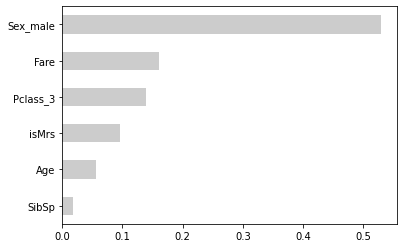

In [104]:
importances = pd.Series(model.feature_importances_)
importances.index = ['Age', 'SibSp', 'Fare', 'isMrs', 'Pclass_3', 'Sex_male']
importances.sort_values(ascending=True, inplace=True)
importances.plot.barh(color='#cccccc')
plt.show()

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END clf__learning_rate=0.001, clf__num_leaves=62, sfm__max_features=20; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=94, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=78, sfm__max_features=18; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=9, sfm__max_features=13; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=22, sfm__max_features=12; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=64, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=64, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=61, sfm__max_features=2; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=30, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=41, sfm__max_features=11; total 

[CV] END clf__learning_rate=0.001, clf__num_leaves=62, sfm__max_features=20; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=94, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=78, sfm__max_features=18; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=9, sfm__max_features=13; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=9, sfm__max_features=13; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=22, sfm__max_features=12; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=64, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=61, sfm__max_features=2; total time=   0.3s
[CV] END clf__learning_rate=0.5, clf__num_leaves=30, sfm__max_features=11; total time=   0.3s
[CV] END clf__learning_rate=0.05, clf__num_leaves=41, sfm__max_features=11; total time=   0.3s
[CV] END clf__learning_rate=0.05, clf__num_leaves=9

[CV] END clf__learning_rate=0.001, clf__num_leaves=62, sfm__max_features=20; total time=   0.3s
[CV] END clf__learning_rate=0.05, clf__num_leaves=78, sfm__max_features=18; total time=   0.3s
[CV] END clf__learning_rate=0.001, clf__num_leaves=9, sfm__max_features=13; total time=   0.3s
[CV] END clf__learning_rate=0.001, clf__num_leaves=22, sfm__max_features=12; total time=   0.3s
[CV] END clf__learning_rate=0.05, clf__num_leaves=61, sfm__max_features=2; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=30, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=41, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=57, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=57, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=94, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=2

[CV] END clf__learning_rate=0.5, clf__num_leaves=21, sfm__max_features=17; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=99, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=99, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=71, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=80, sfm__max_features=3; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=90, sfm__max_features=4; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=14, sfm__max_features=19; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=23, sfm__max_features=7; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=75, sfm__max_features=17; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=75, sfm__max_features=17; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=23, sfm

[CV] END clf__learning_rate=0.5, clf__num_leaves=15, sfm__max_features=5; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=47, sfm__max_features=18; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=47, sfm__max_features=18; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=55, sfm__max_features=4; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=20, sfm__max_features=10; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=14, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=90, sfm__max_features=16; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=43, sfm__max_features=20; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=58, sfm__max_features=6; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=58, sfm__max_features=6; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=83, sfm__

[CV] END clf__learning_rate=0.3, clf__num_leaves=43, sfm__max_features=6; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=43, sfm__max_features=6; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=2, sfm__max_features=7; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=44, sfm__max_features=8; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=97, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=11, sfm__max_features=20; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=98, sfm__max_features=9; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=98, sfm__max_features=9; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=83, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=83, sfm__max_features=9; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=34, sfm__ma

[CV] END clf__learning_rate=0.05, clf__num_leaves=8, sfm__max_features=12; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=62, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=79, sfm__max_features=6; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=79, sfm__max_features=6; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=67, sfm__max_features=6; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=75, sfm__max_features=3; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=93, sfm__max_features=8; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=96, sfm__max_features=2; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=40, sfm__max_features=8; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=53, sfm__max_features=20; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=33, s

[CV] END clf__learning_rate=0.01, clf__num_leaves=57, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=57, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=23, sfm__max_features=13; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=92, sfm__max_features=6; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=74, sfm__max_features=10; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=61, sfm__max_features=3; total time=   0.3s
[CV] END clf__learning_rate=0.01, clf__num_leaves=16, sfm__max_features=2; total time=   0.3s
[CV] END clf__learning_rate=0.5, clf__num_leaves=80, sfm__max_features=7; total time=   0.3s
[CV] END clf__learning_rate=0.005, clf__num_leaves=44, sfm__max_features=5; total time=   0.3s
[CV] END clf__learning_rate=0.001, clf__num_leaves=65, sfm__max_features=17; total time=   0.3s
[CV] END clf__learning_rate=0.3, clf__num_leaves=16, 

[CV] END clf__learning_rate=0.01, clf__num_leaves=55, sfm__max_features=13; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=49, sfm__max_features=19; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=18, sfm__max_features=2; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=20, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=20, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=4, sfm__max_features=3; total time=   0.1s
[CV] END clf__learning_rate=0.5, clf__num_leaves=70, sfm__max_features=19; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=48, sfm__max_features=5; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=29, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=29, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=7

[CV] END clf__learning_rate=0.3, clf__num_leaves=51, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=39, sfm__max_features=16; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=61, sfm__max_features=7; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=58, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=77, sfm__max_features=8; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=17, sfm__max_features=18; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=27, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=87, sfm__max_features=19; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=87, sfm__max_features=19; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=63, sfm__max_features=16; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=43, sfm

[CV] END clf__learning_rate=0.001, clf__num_leaves=21, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=68, sfm__max_features=15; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=89, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=89, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=89, sfm__max_features=2; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=84, sfm__max_features=12; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=38, sfm__max_features=8; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=17, sfm__max_features=3; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=79, sfm__max_features=20; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=71, sfm__max_features=7; total time=   0.3s
[CV] END clf__learning_rate=0.05, clf__num_leaves=58, sfm__

[CV] END clf__learning_rate=0.05, clf__num_leaves=33, sfm__max_features=8; total time=   0.3s
[CV] END clf__learning_rate=0.005, clf__num_leaves=21, sfm__max_features=17; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=99, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=99, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=22, sfm__max_features=10; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=26, sfm__max_features=11; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=61, sfm__max_features=16; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=30, sfm__max_features=3; total time=   0.2s
[CV] END clf__learning_rate=0.001, clf__num_leaves=30, sfm__max_features=3; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=44, sfm__max_features=3; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=14

[CV] END clf__learning_rate=0.1, clf__num_leaves=32, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=32, sfm__max_features=14; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=12, sfm__max_features=2; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=99, sfm__max_features=7; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=6, sfm__max_features=2; total time=   0.1s
[CV] END clf__learning_rate=0.05, clf__num_leaves=65, sfm__max_features=16; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=44, sfm__max_features=2; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=44, sfm__max_features=2; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=79, sfm__max_features=5; total time=   0.2s
[CV] END clf__learning_rate=0.3, clf__num_leaves=7, sfm__max_features=19; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=96, sfm__m

[CV] END clf__learning_rate=0.005, clf__num_leaves=56, sfm__max_features=3; total time=   0.2s
[CV] END clf__learning_rate=0.005, clf__num_leaves=56, sfm__max_features=3; total time=   0.2s
[CV] END clf__learning_rate=0.1, clf__num_leaves=66, sfm__max_features=16; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=63, sfm__max_features=9; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=95, sfm__max_features=8; total time=   0.2s
[CV] END clf__learning_rate=0.05, clf__num_leaves=79, sfm__max_features=19; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=25, sfm__max_features=9; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=61, sfm__max_features=13; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=61, sfm__max_features=13; total time=   0.2s
[CV] END clf__learning_rate=0.5, clf__num_leaves=83, sfm__max_features=16; total time=   0.2s
[CV] END clf__learning_rate=0.01, clf__num_leaves=41, sf

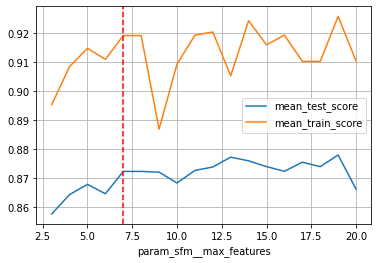

Melhor modelo simples
{'sfm__max_features': 7, 'clf__num_leaves': 44, 'clf__learning_rate': 0.01}
['Age', 'SibSp', 'Fare', 'isMr', 'isMrs', 'Pclass_3', 'Sex_male']
TEST  81.28
TRAIN 92.22


In [58]:
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

# Select K Best
params = {'sfm__max_features': range(2, x.shape[1] + 1), 
          'clf__num_leaves': range(2, 100),
          'clf__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]}
    
classifier_1 = Pipeline([('sfm', SelectFromModel(RandomForestClassifier(n_estimators=100))),
                         ('clf', LGBMClassifier())])

grid = RandomizedSearchCV(classifier_1, 
                    params, 
                    scoring='roc_auc',
                    n_iter=500,
                    n_jobs=5,
                    cv=5,
                    verbose=2,
                    return_train_score=True)

grid.fit(x_train, y_train.values.ravel())

results = pd.DataFrame(grid.cv_results_)
results['diff'] = (results['mean_train_score'] - results['mean_test_score']) < 0.05
results = results[results['diff'] == True]
results.sort_values(by=['param_sfm__max_features', 'rank_test_score'], ascending=True, inplace=True)
results.drop_duplicates(subset=['param_sfm__max_features'], keep='first', inplace=True)

results_plot = results.loc[:, ['param_sfm__max_features', 'mean_test_score', 'mean_train_score']]
results_plot.set_index('param_sfm__max_features', inplace=True)
# Select best within margin
threshold = results_plot.mean_test_score.max() - 0.01
best_est = results_plot.loc[results_plot.mean_test_score >= threshold, :].index.min()

print("Best Parameters")
print("\t", results.loc[results.param_sfm__max_features == best_est].params.values[0])


results_plot.plot()
plt.grid()
plt.axvline(best_est, color='red', ls='--')
plt.show()

# -------------------

simple_params = results.loc[results.param_sfm__max_features == best_est].params.values[0]

classifier_1.set_params(**simple_params)
classifier_1.fit(x_train, y_train.values.ravel())
features = colunas[classifier_1.named_steps['sfm'].get_support()]

# Refazendo as features
x_train_refactored =  x_train[:, classifier_1.named_steps['sfm'].get_support()]
x_test_refactored  =  x_test[:, classifier_1.named_steps['sfm'].get_support()]

model = LGBMClassifier(**classifier_1.named_steps['clf'].get_params())
model.fit(x_train_refactored, y_train.values.ravel())

print("Melhor modelo simples\n%s\n%s" % (simple_params, features.tolist()))
prob = model.predict_proba(x_test_refactored)[:, 1]
print("TEST  %4.2f" % (roc_auc_score(y_test, prob) * 100))
prob = model.predict_proba(x_train_refactored)[:, 1]
print("TRAIN %4.2f" % (roc_auc_score(y_train, prob) * 100))

<AxesSubplot:>

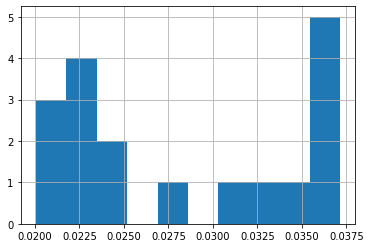

In [65]:
results['std_test_score'].hist()

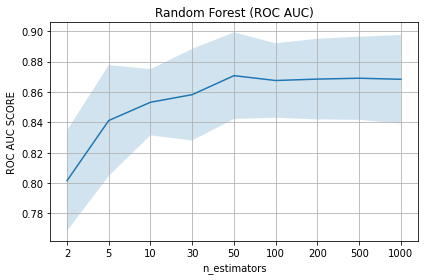

In [135]:
#-----------------------
# Verificando diferentes numeros de árvore em RF
n_estimators = [2, 5, 10, 30, 50, 100, 200, 500, 1000]
from sklearn.model_selection import cross_val_score

scores = pd.DataFrame()
for param_n_estimators in n_estimators:
    rf = RandomForestClassifier(n_estimators=param_n_estimators, n_jobs=1)
    _ = cross_val_score(rf, x_train, y_train.values.ravel(), cv=5, n_jobs=-1, scoring='roc_auc')
    scores = scores.append([[param_n_estimators, np.mean(_), np.std(_)]], ignore_index=True)
scores.columns = ['n_estimators', 'mean_score', 'std_score']

scores_depth5 = pd.DataFrame()
for param_n_estimators in n_estimators:
    rf = RandomForestClassifier(n_estimators=param_n_estimators, max_depth=5, n_jobs=1)
    _ = cross_val_score(rf, x_train, y_train.values.ravel(), cv=5, n_jobs=-1, scoring='roc_auc')
    scores_depth5 = scores_depth5.append([[param_n_estimators, np.mean(_), np.std(_)]], ignore_index=True)
scores_depth5.columns = ['n_estimators', 'mean_score', 'std_score']


plt.title('Random Forest (ROC AUC)')
plt.plot(range(1, len(scores) + 1), scores.mean_score)
plt.xticks(range(1, len(scores) + 1), scores.n_estimators)
plt.fill_between(range(1, len(scores) + 1), 
                 scores.mean_score + scores.std_score,
                 scores.mean_score - scores.std_score, 
                 alpha=0.2)
plt.xlabel('n_estimators')
plt.ylabel('ROC AUC SCORE')
plt.grid()


plt.tight_layout()
plt.show()

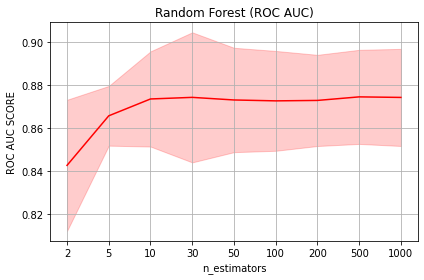

In [137]:
plt.title('Random Forest (ROC AUC)')
plt.plot(range(1, len(scores_depth5) + 1), scores_depth5.mean_score, color='r')
plt.xticks(range(1, len(scores_depth5) + 1), scores_depth5.n_estimators)
plt.fill_between(range(1, len(scores) + 1), 
                 scores_depth5.mean_score + scores_depth5.std_score,
                 scores_depth5.mean_score - scores_depth5.std_score, 
                 alpha=0.2,
                 color='r')
plt.xlabel('n_estimators')
plt.ylabel('ROC AUC SCORE')
plt.grid()


plt.tight_layout()
plt.show()

In [117]:
scores = pd.Series(scores)
scores

0    [0.8991735537190082, 0.8792355371900826, 0.834...
1    [0.881198347107438, 0.8477272727272727, 0.8323...
2    [0.9020661157024794, 0.8805785123966943, 0.862...
3    [0.9019628099173553, 0.8734504132231404, 0.852...
4    [0.9050619834710744, 0.8732438016528925, 0.861...
5    [0.9037190082644628, 0.8759297520661158, 0.870...
6    [0.908987603305785, 0.8737603305785123, 0.8700...
7    [0.9076446280991736, 0.8714876033057851, 0.868...
dtype: object

In [117]:
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier

# Select K Best
params = {'sfm__max_features': range(2, x.shape[1] + 1), 
          'clf__n_estimators': range(1, 200),
          'clf__num_leaves': range(2, 90),
          'clf__learning_rate': [1e16, 1e-3, 1e-2, 0.05, 0.3]}
    

classifier_1 = Pipeline([('sfm', SelectFromModel(LGBMClassifier())),
                         ('clf', LGBMClassifier())])

grid = RandomizedSearchCV(classifier_1,
                          params,
                          n_iter=200,
                          scoring='roc_auc',
                          n_jobs=5,
                          cv=4,
                          verbose=1,
                          return_train_score=True)

grid.fit(x_train, y_train.values.ravel())

Fitting 4 folds for each of 200 candidates, totalling 800 fits


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('sfm',
                                              SelectFromModel(estimator=LGBMClassifier())),
                                             ('clf', LGBMClassifier())]),
                   n_iter=200, n_jobs=5,
                   param_distributions={'clf__learning_rate': [1e+16, 0.001,
                                                               0.01, 0.05,
                                                               0.3],
                                        'clf__n_estimators': range(1, 200),
                                        'clf__num_leaves': range(2, 90),
                                        'sfm__max_features': range(2, 21)},
                   return_train_score=True, scoring='roc_auc', verbose=1)

Best Parameters
	 {'sfm__max_features': 10, 'clf__num_leaves': 3, 'clf__n_estimators': 138, 'clf__learning_rate': 0.001}


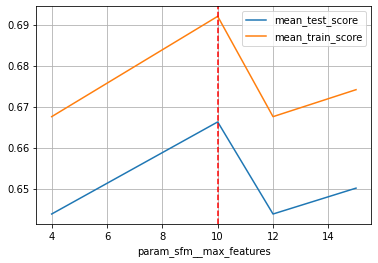

In [118]:
results = pd.DataFrame(grid.cv_results_)
results['diff'] = (results['mean_train_score'] - results['mean_test_score']) < 0.03
results = results[results['diff'] == True]
results.sort_values(by=['param_sfm__max_features', 'rank_test_score'], ascending=True, inplace=True)
results.drop_duplicates(subset=['param_sfm__max_features'], keep='first', inplace=True)

results_plot = results.loc[:, ['param_sfm__max_features', 'mean_test_score', 'mean_train_score']]
results_plot.set_index('param_sfm__max_features', inplace=True)
# Select best within margin
threshold = results_plot.mean_test_score.max() - 0.01
best_est = results_plot.loc[results_plot.mean_test_score >= threshold, :].index.min()

print("Best Parameters")
print("\t", results.loc[results.param_sfm__max_features == best_est].params.values[0])


results_plot.plot()
plt.grid()
plt.axvline(best_est, color='red', ls='--')
plt.show()

In [115]:
est = grid.best_estimator_
print("Melhor modelo")
print(grid.best_params_)
prob = est.predict_proba(x_test)[:, 1]
print("TEST  %4.2f" % (roc_auc_score(y_test, prob) * 100))
prob = est.predict_proba(x_train)[:, 1]
print("TRAIN %4.2f" % (roc_auc_score(y_train, prob) * 100))

Melhor modelo
{'sfm__max_features': 5, 'clf__num_leaves': 45, 'clf__n_estimators': 20, 'clf__learning_rate': 0.3}
TEST  59.64
TRAIN 92.15


In [116]:
simple_params = results.loc[results.param_sfm__max_features == best_est].params.values[0]

classifier_1.set_params(**simple_params)
classifier_1.fit(x_train, y_train)

features = colunas[classifier_1.named_steps['sfm'].get_support()]
print("Melhor modelo simples\n%s\n%s" % (simple_params, features.tolist()))
prob = classifier_1.predict_proba(x_test)[:, 1]
print("TEST  %4.2f" % (roc_auc_score(y_test, prob) * 100))
prob = classifier_1.predict_proba(x_train)[:, 1]
print("TRAIN %4.2f" % (roc_auc_score(y_train, prob) * 100))

Melhor modelo simples
{'sfm__max_features': 2, 'clf__num_leaves': 2, 'clf__n_estimators': 198, 'clf__learning_rate': 0.01}
['Age', 'Fare']
TEST  65.93
TRAIN 73.33


/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/mash/Documents/ML/Titanic/myenv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Index(['Age', 'Fare'], dtype='object')

In [156]:
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier

# Select K Best
params = {'sfm__max_features': range(2, x.shape[1] + 1), 
          'clf__n_estimators': range(1, 300),
          'clf__max_depth': range(1, 40)}
    

classifier_1 = Pipeline([('sfm', SelectFromModel(RandomForestClassifier())),
                         ('clf', RandomForestClassifier())])

grid = RandomizedSearchCV(classifier_1,
                          params,
                          n_iter=200,
                          scoring='roc_auc',
                          n_jobs=5,
                          cv=4,
                          verbose=1,
                          return_train_score=True)

grid.fit(x_train, y_train.values.ravel())

Fitting 4 folds for each of 200 candidates, totalling 800 fits


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('sfm',
                                              SelectFromModel(estimator=RandomForestClassifier())),
                                             ('clf',
                                              RandomForestClassifier())]),
                   n_iter=200, n_jobs=5,
                   param_distributions={'clf__max_depth': range(1, 40),
                                        'clf__n_estimators': range(1, 300),
                                        'sfm__max_features': range(2, 21)},
                   return_train_score=True, scoring='roc_auc', verbose=1)

Best Parameters
	 {'sfm__max_features': 3, 'clf__n_estimators': 165, 'clf__max_depth': 3}


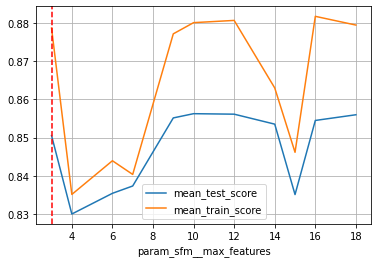

In [157]:
results = pd.DataFrame(grid.cv_results_)
results['diff'] = (results['mean_train_score'] - results['mean_test_score']) < 0.03
results = results[results['diff'] == True]
results.sort_values(by=['param_sfm__max_features', 'rank_test_score'], ascending=True, inplace=True)
results.drop_duplicates(subset=['param_sfm__max_features'], keep='first', inplace=True)

results_plot = results.loc[:, ['param_sfm__max_features', 'mean_test_score', 'mean_train_score']]
results_plot.set_index('param_sfm__max_features', inplace=True)
# Select best within margin
threshold = results_plot.mean_test_score.max() - 0.01
best_est = results_plot.loc[results_plot.mean_test_score >= threshold, :].index.min()

print("Best Parameters")
print("\t", results.loc[results.param_sfm__max_features == best_est].params.values[0])


results_plot.plot()
plt.grid()
plt.axvline(best_est, color='red', ls='--')
plt.show()

In [159]:
simple_params = results.loc[results.param_sfm__max_features == best_est].params.values[0]

classifier_1.set_params(**simple_params)
classifier_1.fit(x_train, y_train)
features = colunas[classifier_1.named_steps['sfm'].get_support()]

# Refazendo as features
x_train_refactored =  x_train[:, classifier_1.named_steps['sfm'].get_support()]
x_test_refactored  =  x_test[:, classifier_1.named_steps['sfm'].get_support()]

model = RandomForestClassifier(**classifier_1.named_steps['clf'].get_params())
model.fit(x_train_refactored, y_train)

print("Melhor modelo simples\n%s\n%s" % (simple_params, features.tolist()))
prob = model.predict_proba(x_test_refactored)[:, 1]
print("TEST  %4.2f" % (roc_auc_score(y_test, prob) * 100))
prob = model.predict_proba(x_train_refactored)[:, 1]
print("TRAIN %4.2f" % (roc_auc_score(y_train, prob) * 100))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Melhor modelo simples
{'sfm__max_features': 3, 'clf__n_estimators': 165, 'clf__max_depth': 3}
['Age', 'Fare', 'Sex_male']
TEST  80.48
TRAIN 87.55


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [160]:
import shap

explainer = shap.TreeExplainer(model)

x_test_1 = pd.DataFrame(x_test_refactored)
x_test_1.columns = features

shap_values = explainer.shap_values(x_test_1)

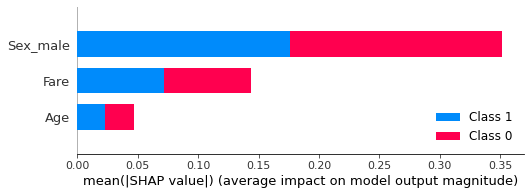

In [161]:
shap.summary_plot(shap_values, x_test_1)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


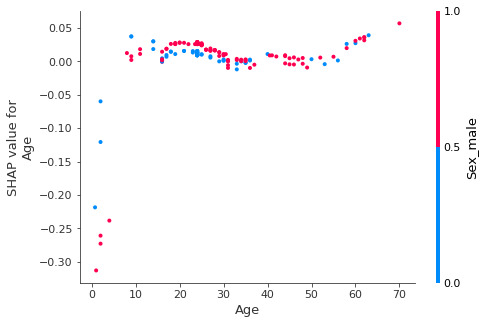

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


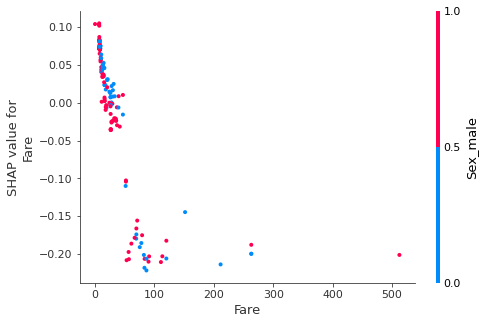

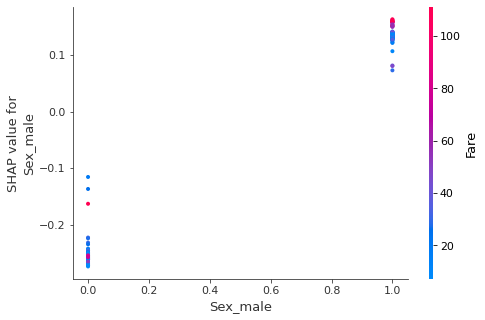

In [162]:
for name in x_test_1.columns:
    shap.dependence_plot(name, shap_values[0], x_test_1, display_features=x_test_1)

In [197]:
volume = np.array([900349,1072862, 846860, 57863, 59264, 985665, 1169739])  * 1e-8
entry = np.array([1500,1970,1477.50,98.50,98.50, 1970, 2462.50])
prices = entry / volume

np.sum(volume), np.sum(entry)

(0.050926019999999995, 9577.0)

In [198]:
preco_medio = np.average(prices, weights=volume)
"%4.2f" % preco_medio

'188057.11'